# Table of Contents

1. [Import Packages](#import-packages) 
2. [Import Mouse Metadata](#import-mouse-metadata)
3. [Import CoMPASS CSV file with EEG data combined](#import-compass-csv-file-with-eeg-data-combined)
4. [Gamma & Theta Power across Level 1 States](#gamma--theta-power-across-level-1-states)
5. [Gamma & Theta Power across Level 2 States](#gamma--theta-power-across-level-2-states)
6. [Gamma Distribution at Key spatial locations across HHMM States](#gamma-distribution-at-key-spatial-locations-across-hhmm-states)
7. [Power/Velocity by Node Type across Level 1 States](#powervelocity-by-node-type-across-level-1-states)
8. [Power across Level 2 States per Region](#power-across-level-2-states-per-regions)
9. [Feature KDE per State](#feature-kde-per-state)
10. [Power across Level 2 States per Velocity Bin](#power-across-level-2-states-per-velocity-bin)
11. [Correlation Matrices](#correlation-matrices)
12. [Boutwise Neural Dynamics](#boutwise-neural-dynamics)
13. [Gamma Trends at Decision Points across HHMM State transition points](#gamma-trends-at-decision-points-across-hhmm-state-transition-points)
14. [UMAPS](#umaps)
15. [UMAP - Temporal Progression](#umap---temporal-progression)
16. [Classification Modeling](#classification-modeling)

# Import Packages

In [ ]:
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
# autoreload (mainly for testing purposes)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
CUSTOM_UTILS_PATH = Path(os.getcwd()).parent/'src'/'neural'/'ephys_behavior_analysis'
if CUSTOM_UTILS_PATH.exists():
    sys.path.append(str(CUSTOM_UTILS_PATH))
    # Import custom analysis modules
    try:
        import boutwise_neural_dynamics
        from boutwise_neural_dynamics import *
        import classification_modeling
        from classification_modeling import *
        import correlation_analysis
        from correlation_analysis import *
        import power_state_analysis
        from power_state_analysis import *
        import umaps_state_temporal_embedding
        from umaps_state_temporal_embedding import *
        print("Utils loaded successfully!")
    except ImportError as e:
        print(f"Warning: Could not import custom modules: {e}")
else:
    print(f"Warning: Custom utils path not found: {CUSTOM_UTILS_PATH}")


import init_config
from init_config import *

import notebook_utils
from notebook_utils import *

In [4]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['pdf.fonttype'] = 42

# Import Mouse Metadata

In [ ]:
# Read in mouse metadata file
mouseinfo = pd.read_excel(os.path.join(METADATA_PATH,METADATA_FILE), sheet_name=TRIAL_TYPE)
print('Metadata columns: ',mouseinfo.columns)

# Consider only non-NA Sessions
mouseinfo = mouseinfo[~mouseinfo['Session #'].isna()]

# Find the subset of trials need to be excluded
mouseinfo = mouseinfo.loc[mouseinfo['Exclude Trial']!= 'yes'].reset_index(drop=True)

# Import CoMPASS CSV file with EEG data combined

In [ ]:
df_tot = pd.read_csv(os.path.join(BASE_PATH,'csvs','combined','CoMPASS_EEG_comb.csv'),index_col=0)

# Gamma & Theta Power across Level 1 States

In [88]:
# Define mapping dictionary
state_map = {
    1: 'Surveillance',
    2: 'Ambulatory'
}

# Apply mapping using map (preserves NaNs for unmapped values)
df_tot['HMM State'] = df_tot['HMM_State'].map(state_map)


C:\Users\shreya.bangera\Gladstone Dropbox\Palop Lab\Shreya\Labyrinth Project Folders\CoMPASS-Labyrinth\src\neural\ephys_behavior_analysis\power_state_analysis.py:83: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.barplot(



MixedLM Result: GAMMA Power across States
→ Comparing: Ambulatory (reference) vs Surveillance
               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    Power       
No. Observations:     220612     Method:                REML        
No. Groups:           5          Scale:                 0.6945      
Min. group size:      25215      Log-Likelihood:        -272848.7524
Max. group size:      64976      Converged:             Yes         
Mean group size:      44122.4                                       
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 2.957    0.438   6.746 0.000  2.098  3.816
C(State)[T.Surveillance] -0.275    0.004 -77.003 0.000 -0.282 -0.268
Group Var                 0.961    0.622                            

  ↳ Effect of 'C(State)

c:\Users\shreya.bangera\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\shreya.bangera\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(



MixedLM Result: THETA Power across States
→ Comparing: Ambulatory (reference) vs Surveillance
               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    Power       
No. Observations:     220612     Method:                REML        
No. Groups:           5          Scale:                 0.9046      
Min. group size:      25215      Log-Likelihood:        -301994.3939
Max. group size:      64976      Converged:             Yes         
Mean group size:      44122.4                                       
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 2.359    0.051  46.690 0.000  2.260  2.458
C(State)[T.Surveillance] -0.312    0.004 -76.542 0.000 -0.320 -0.304
Group Var                 0.013    0.010                            

  ↳ Effect of 'C(State)

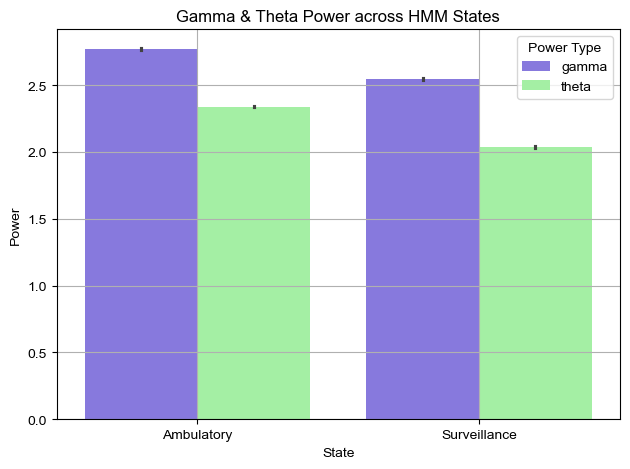

In [23]:
# ======================== USAGE EXAMPLE: HMM State ======================== #
# This workflow compares gamma and theta power across Level 1 HMM states
# using grouped barplots and a mixed-effects model to assess statistical differences.
#
# Recommended Use:
# ----------------
# 1. Run `prepare_power_comparison_data(df_tot, state_col='HMM State')` 
#    to reshape the dataframe for long-form analysis.
#
# 2. Use `plot_power_comparison_by_state()` to visualize gamma and theta 
#    power across HMM states.
#
# 3. Run `run_mixedlm_for_power()` to fit a MixedLM testing for 
#    power differences across HMM States with Session as a random effect.
#
# 4. Inspect printed model summaries for coefficients and p-values 
#    to determine if state-based differences are significant.

# ---------------- EXAMPLE ---------------- #
# Step 1: Prepare data
df_power_melted = prepare_power_comparison_data(
    df_power=df_tot, 
    power_cols=['gamma', 'theta'],
    state_col='HMM State',
    group_col='Session'
)

# Step 2: Plot
plot_power_comparison_by_state(
    df_power_melted,
    state_order=['Ambulatory', 'Surveillance'],
    palette=None,
    title="Gamma & Theta Power across HMM States"
)

# Step 3: Mixed model
summary_df = run_mixedlm_for_power(
    df_power_melted,
    power_cols=['gamma', 'theta'],
    states_to_compare=['Ambulatory', 'Surveillance']
)


# Gamma & Theta Power across Level 2 States

C:\Users\shreya.bangera\Gladstone Dropbox\Palop Lab\Shreya\Labyrinth Project Folders\CoMPASS-Labyrinth\src\neural\ephys_behavior_analysis\power_state_analysis.py:83: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.barplot(



MixedLM Result: GAMMA Power across States
→ Comparing: Active Surveillance, Reward-oriented (reference) vs Active Surveillance, Non-reward oriented
                             Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             Power       
No. Observations:               104690              Method:                         REML        
No. Groups:                     5                   Scale:                          0.7838      
Min. group size:                10711               Log-Likelihood:                 -135823.1984
Max. group size:                33714               Converged:                      Yes         
Mean group size:                20938.0                                                         
------------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------

c:\Users\shreya.bangera\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


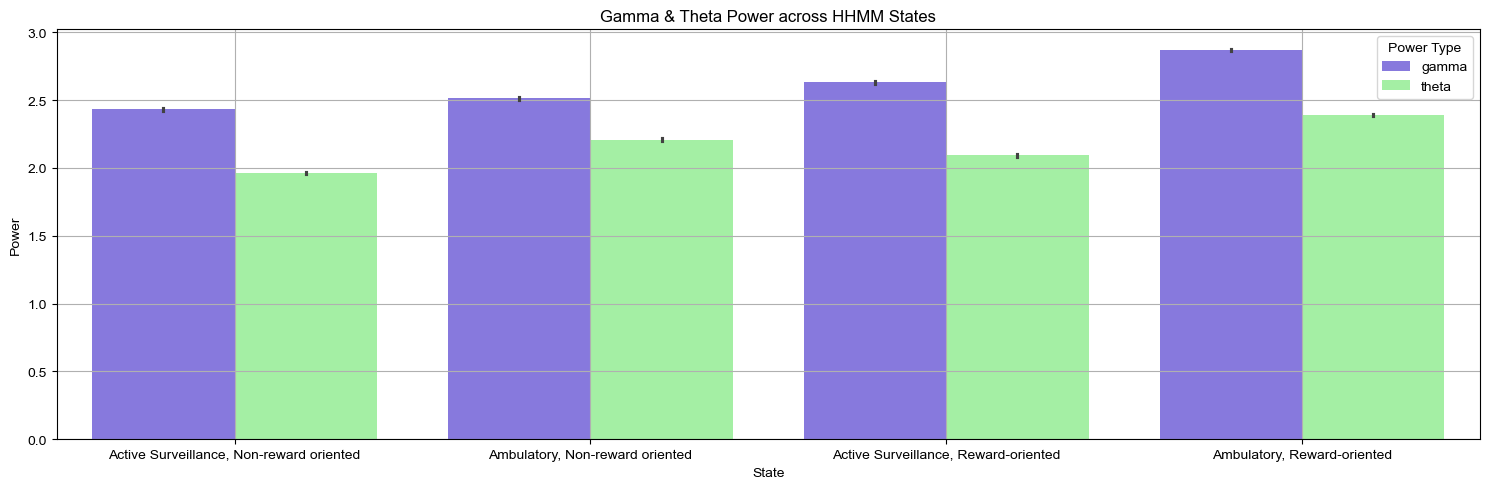

In [24]:
# ======================== USAGE EXAMPLE: HHMM State ======================== #
# This variant applies the same power comparison workflow to Level 2 HHMM states,
# commonly used for decoding latent motivation or reward-oriented strategies.
#
# Recommended Use:
# ----------------
# 1. Run `prepare_power_comparison_data(df_tot, state_col='HHMM State')`
#    to reshape data for multi-power analysis.
#
# 2. Use `plot_power_comparison_by_state()` to visualize power distributions 
#    across HHMM state labels.
#
# 3. Run `run_mixedlm_for_power()` for MixedLM statistical testing with Session as random effect.
#
# 4. Use printed output and returned DataFrame to summarize power effects per HHMM state.

# ---------------- EXAMPLE ---------------- #
# Step 1: Prepare data
df_power_melted = prepare_power_comparison_data(
    df_power=df_tot, 
    power_cols=['gamma', 'theta'],
    state_col='HHMM State',
    group_col='Session'
)

# Step 2: Plot
plot_power_comparison_by_state(
    df_power_melted,
    state_order=None,
    palette=None,figure_size=(15,5),
    title="Gamma & Theta Power across HHMM States"
)

# # Step 3: Mixed model
summary_df = run_mixedlm_for_power(
    df_power_melted,
    power_cols=['gamma', 'theta'],
    states_to_compare=['Active Surveillance, Reward-oriented','Active Surveillance, Non-reward oriented']
)


# Gamma Distribution at Key spatial locations across HHMM States

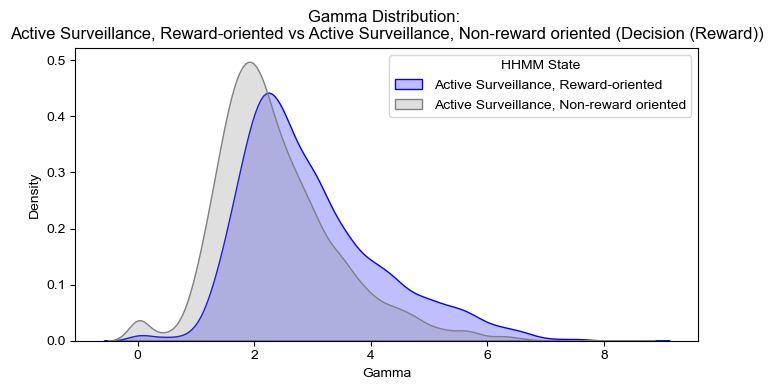

Median Wasserstein Distance: 0.43644269126322266


C:\Users\shreya.bangera\Gladstone Dropbox\Palop Lab\Shreya\Labyrinth Project Folders\CoMPASS-Labyrinth\src\neural\ephys_behavior_analysis\power_state_analysis.py:234: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Session", y="Observed Wasserstein Distance", data=result_df, palette="viridis")


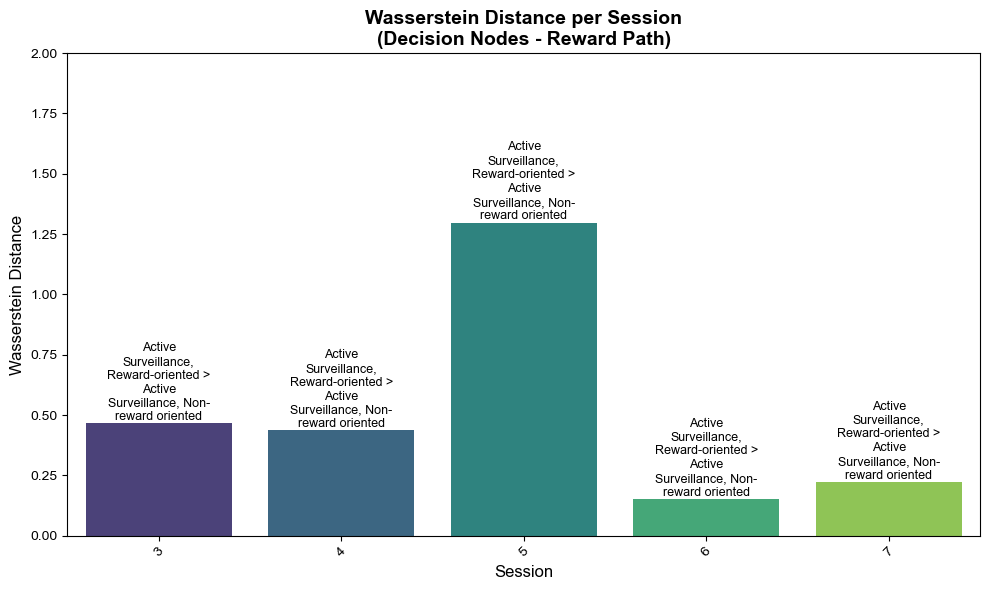

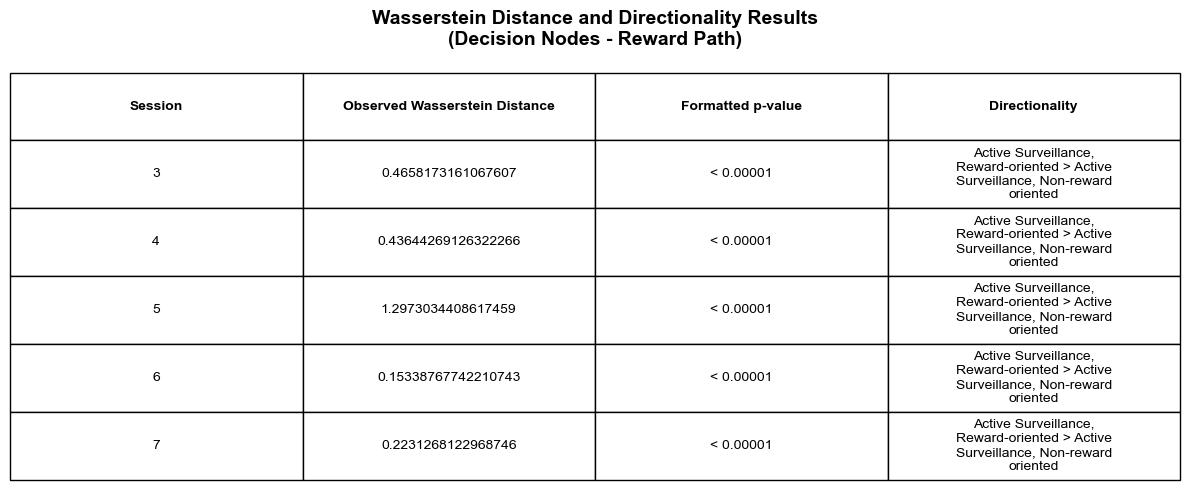

In [25]:
# ======================== USAGE EXAMPLE: HHMM State (Wasserstein Distance) ======================== #
# This workflow compares the distribution of power (e.g., gamma) between two HHMM states across sessions,
# using the Wasserstein distance with permutation testing to assess distributional shifts and directionality.
#
# Recommended Use:
# ----------------
# 1. Use `plot_gamma_distribution_kde()` to compare gamma distributions across states (smoothed density).
#
# 2. Run `compute_wasserstein_permutation_test(...)` to compute observed distances, p-values,
#    and directional shifts for each session between two specified state labels.
#
# 3. Format p-values using `Formatted p-value` column for cleaner display.
#
# 4. Use `plot_wasserstein_barplot()` to visualize Wasserstein distances and shifts per session.
#
# 5. Use `plot_wasserstein_table()` to show a tabular summary of distances and statistical outcomes.
#
# 6. Median Wasserstein distance gives a session-aggregated measure of effect size.

# ---------------- EXAMPLE ---------------- #

# Step 1: KDE Distribution Comparison for HHMM State Labels
plot_gamma_distribution_kde(
    df_tot,
    label_col="HHMM State",
    label_1="Active Surveillance, Reward-oriented",
    label_2="Active Surveillance, Non-reward oriented",
    value_col="gamma",
    filter_node_col="NodeType",
    filter_node_val="Decision (Reward)"
)

# Step 2: Compute Wasserstein distances with permutation test
result_df = compute_wasserstein_permutation_test(
    df_tot,
    label_col="HHMM State",
    label_1="Active Surveillance, Reward-oriented",
    label_2="Active Surveillance, Non-reward oriented",
    value_col="gamma",
    node_filter_col="NodeType",
    node_filter_val="Decision (Reward)",  
    n_permutations=1000
)

# Step 3: Format p-values
result_df["Formatted p-value"] = result_df["Permutation p-value"].apply(
    lambda x: f"{x:.5f}" if x != 0 else "< 0.00001"
)

# Step 4: Print summary statistic
print("Median Wasserstein Distance:", result_df["Observed Wasserstein Distance"].median())

# Step 5: Plot barplot of distances
plot_wasserstein_barplot(result_df)

# Step 6: Plot summary table
plot_wasserstein_table(result_df)



# Power/Velocity by Node Type across Level 1 States


MixedLM Result: GAMMA across Node Types (HMM State = Surveillance)
→ Comparing: Decision (Reward) (reference) vs Non-Decision (Reward)
                    Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        gamma      
No. Observations:        25008          Method:                    REML       
No. Groups:              5              Scale:                     0.5813     
Min. group size:         2242           Log-Likelihood:            -28727.5003
Max. group size:         10402          Converged:                 Yes        
Mean group size:         5001.6                                               
------------------------------------------------------------------------------
                                     Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                            2.673    0.487  5.485 0.000  1.718  3.629
C(NodeType)[T.No

{'Surveillance': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x257cb9cd790>,
 'Ambulatory': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x257cb9dbd50>}

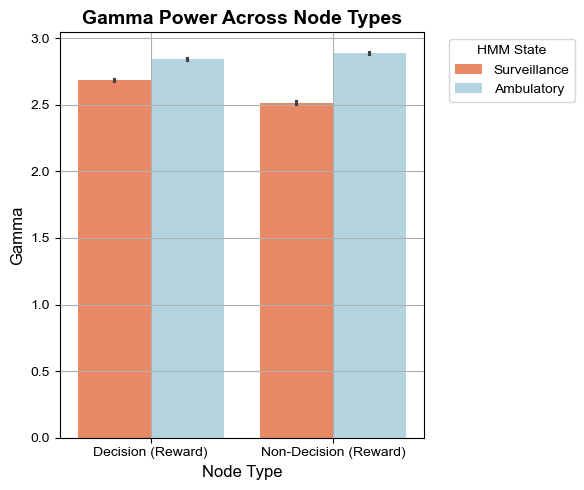

In [26]:
# # ======================== USAGE EXAMPLE ======================== #
# # This workflow compares gamma/theta/velocity across Decision and Non-Decision nodes,
# # visualized via grouped barplots and tested using Mixed Linear Models (optional).
# #
# # Recommended Use:
# # ----------------
# # 1. Run `prepare_node_comparison_data()` to filter and extract only the relevant columns.
# #
# # 2. Use `plot_power_by_nodetype()` to create grouped barplots of power/velocity
# #    split by HMM State and NodeType.
# #
# # 3. Optionally run `run_mixedlm_node_type()` to statistically compare the y variable
# #    across node types with session as a random effect.
# #

# # ---------------- EXAMPLE ---------------- #
# Step 1: Prepare data
df_filtered = prepare_node_comparison_data(df_tot, y_col='gamma', 
                                  node_types=['Decision (Reward)', 'Non-Decision (Reward)'], 
                                  required_cols=['Session', 'Region', 'NodeType', 'HMM State'])

# Step 2: Plot Gamma Power by Node Type
plot_power_by_nodetype(
    df_filtered,
    y_col='gamma',
    node_order=['Decision (Reward)', 'Non-Decision (Reward)'],
    figsize=(6, 5),
    palette=['coral', 'lightblue'],
    title='Gamma Power Across Node Types'
)

# Step 3: Fit Mixed Linear Model for gamma
run_mixedlm_node_type_by_hmmstate(df_filtered, y_col='gamma')


# Feature KDE per State

C:\Users\shreya.bangera\Gladstone Dropbox\Palop Lab\Shreya\Labyrinth Project Folders\CoMPASS-Labyrinth\src\neural\ephys_behavior_analysis\power_state_analysis.py:649: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=subset, shade=True,
C:\Users\shreya.bangera\Gladstone Dropbox\Palop Lab\Shreya\Labyrinth Project Folders\CoMPASS-Labyrinth\src\neural\ephys_behavior_analysis\power_state_analysis.py:649: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=subset, shade=True,
C:\Users\shreya.bangera\Gladstone Dropbox\Palop Lab\Shreya\Labyrinth Project Folders\CoMPASS-Labyrinth\src\neural\ephys_behavior_analysis\power_state_analysis.py:649: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error

<Axes: title={'center': 'Velocity KDE by HHMM State'}, xlabel='Velocity', ylabel='Density'>

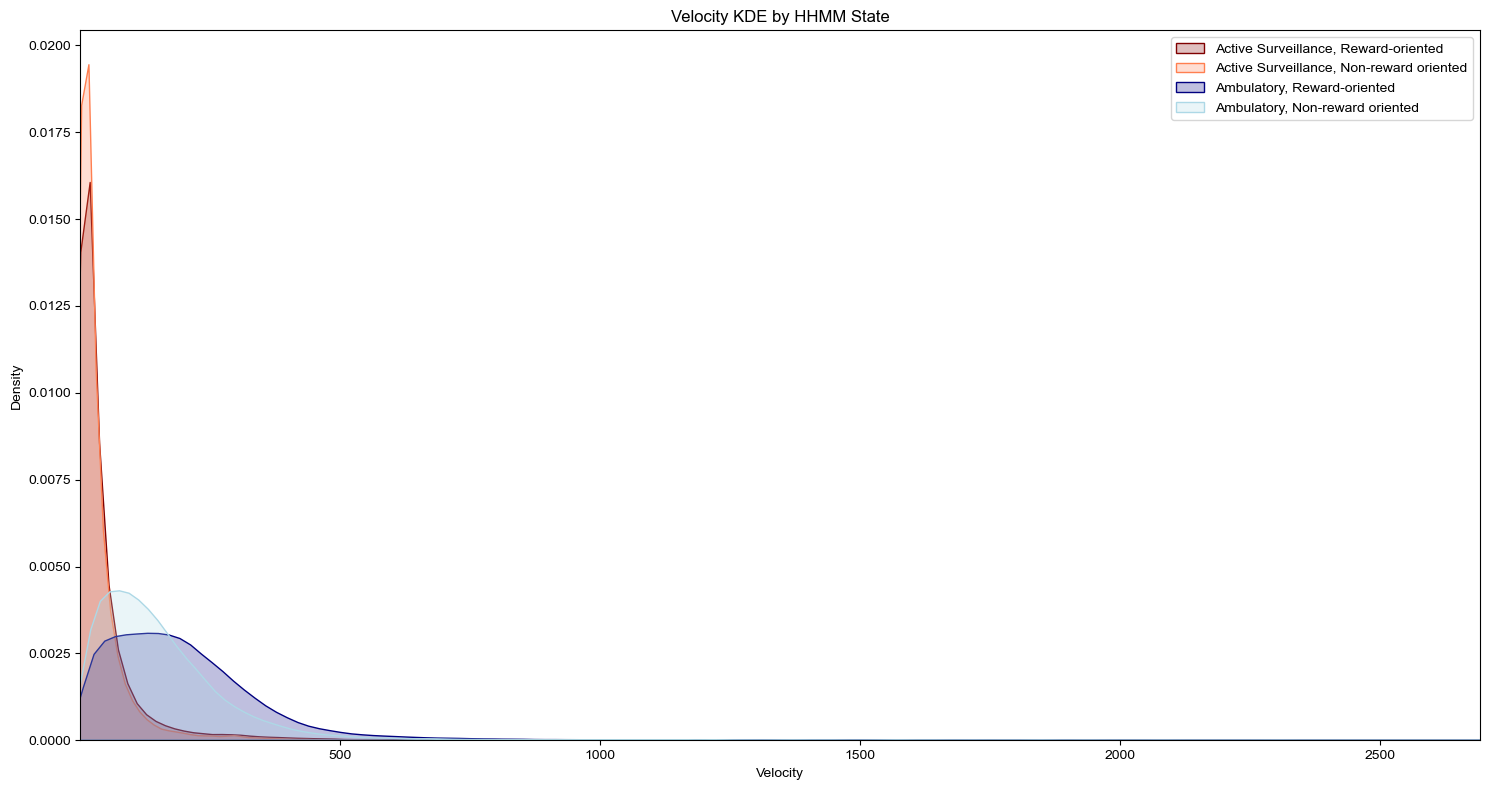

In [31]:
# ======================== USAGE EXAMPLE ======================== #
# This function plots KDE curves for Velocity across HHMM State groups.
# Optional dynamic x-limit is calculated by identifying where all KDEs drop below a specified density.

# Recommended Usage:
# ------------------
# 1. Specify the `df` with velocity and HHMM state columns.
# 2. Define the state groups and color palette to use.
# 3. Set `use_dynamic_cutoff=True` to auto-limit the x-axis based on merging point.

# Example Workflow:
# -----------------

#--------------- SET THESE VALUES --------------#
group_list = [
    'Active Surveillance, Reward-oriented',
    'Active Surveillance, Non-reward oriented',
    'Ambulatory, Reward-oriented',
    'Ambulatory, Non-reward oriented'
]

color_map = {
    'Active Surveillance, Reward-oriented': 'maroon',
    'Active Surveillance, Non-reward oriented': 'coral',
    'Ambulatory, Reward-oriented': 'navy',
    'Ambulatory, Non-reward oriented': 'lightblue'
}

metric='Velocity'

#________________________________________________________________
# Run plot with dynamic x-axis cutoff
plot_metric_kde_by_state(
    df=df_tot,
    state_col='HHMM State',
    metric=metric,
    groups=group_list,
    palette=color_map,
    use_dynamic_cutoff=True,
    density_thresh=0.0000001,
    figsize=(15, 8)
)


# Power across Level 2 States per Velocity Bin

In [ ]:
# ======================== USAGE EXAMPLE ======================== #
# This workflow compares gamma/theta/velocity across velocity bins
# (e.g., Bin1–Bin5), grouped by HHMM State, using barplots and pairwise
# Linear Mixed Models (LMMs) for statistical testing across Decision nodes.
#
# Recommended Use:
# ----------------
# 1. Use `create_velocity_bins(df, velocity_col='Velocity', num_bins=5)` to create
#    a new column `Velocity_Bins` within each session based on quantile binning.
#
# 2. Define your own list of HHMM State group comparisons using
#    (Velocity Bin, Group1, Group2) triplets. For example:
#    ('Bin1', 'Active Surveillance, Reward-oriented', 'Active Surveillance, Non-reward oriented')
#
# 3. Use `plot_velocity_bin_barplot(...)` to visualize HHMM State group
#    differences across velocity bins using grouped barplots.
#
# 4. Use `analyze_velocity_bin_comparisons(...)` to run Linear Mixed Models
#    per bin + group comparison pair (with Session as a random effect).
#    Results include group p-values and model stats.

# Example Workflow:
# -----------------

#--------------- SET THESE VALUES --------------#
state_col = 'HHMM State'
node_filter = 'Decision (Reward)'
metric = 'Velocity'
num_bins = 5
bins = [f"Bin{i+1}" for i in range(num_bins)]

surveillance_comparisons = [
    (b, 'Active Surveillance, Reward-oriented', 'Active Surveillance, Non-reward oriented') for b in bins
]
ambulatory_comparisons = [
    (b, 'Ambulatory, Reward-oriented', 'Ambulatory, Non-reward oriented') for b in bins
]
custom_comparisons = surveillance_comparisons + ambulatory_comparisons

#____________________________________________________________________________
#--------------- STEP 1: CREATE VELOCITY BINS --------------#
df_tot=ensure_velocity_column(df_tot)
df_binned = create_velocity_bins(df_tot, col_of_interest=metric, num_bins=num_bins)


#--------------- STEP 2: PLOT BARPLOT (OPTIONAL) --------------#
fig, ax = plot_velocity_bin_barplot(
    df_binned,
    metric=metric,
    state_col=state_col,
    node_filter=node_filter,
    y_max=500
)

#--------------- STEP 3: RUN LMM COMPARISONS --------------#
stats_df = analyze_velocity_bin_comparisons(
    df=df_tot,
    metric=metric,
    num_bins=num_bins,
    state_col=state_col,
    node_filter=node_filter,
    custom_comparisons=custom_comparisons
)

#--------------- STEP 4: PRINT RESULTS --------------#
print("=== Linear Mixed Model (LMM) Comparison Results ===")
print(stats_df.to_string(index=False))


# Correlation Matrices

In [ ]:
# ======================== USAGE EXAMPLE ======================== #
# Compute per-bout transition probabilities and feature summaries
# for each decision node (e.g., gamma, theta, velocity).
#
# This can be used for heatmap analysis of reward-optimal transitions
# and neuronal correlates across decision points.
#
# ---------------- EXAMPLE ---------------- #


# Automatically adds velocity if not already present
df_tot = ensure_velocity_column(df_tot)

# Heatmap dataframe created
index_df = compute_decision_node_metrics(
    df_tot,
    decision_nodes=Decision_Reward,
    features=['gamma', 'theta', 'Velocity'],
    grid_anchor=47
)

# View result
index_df.head()


Text(0.5, 1.0, 'Feature Correlation Heatmap')

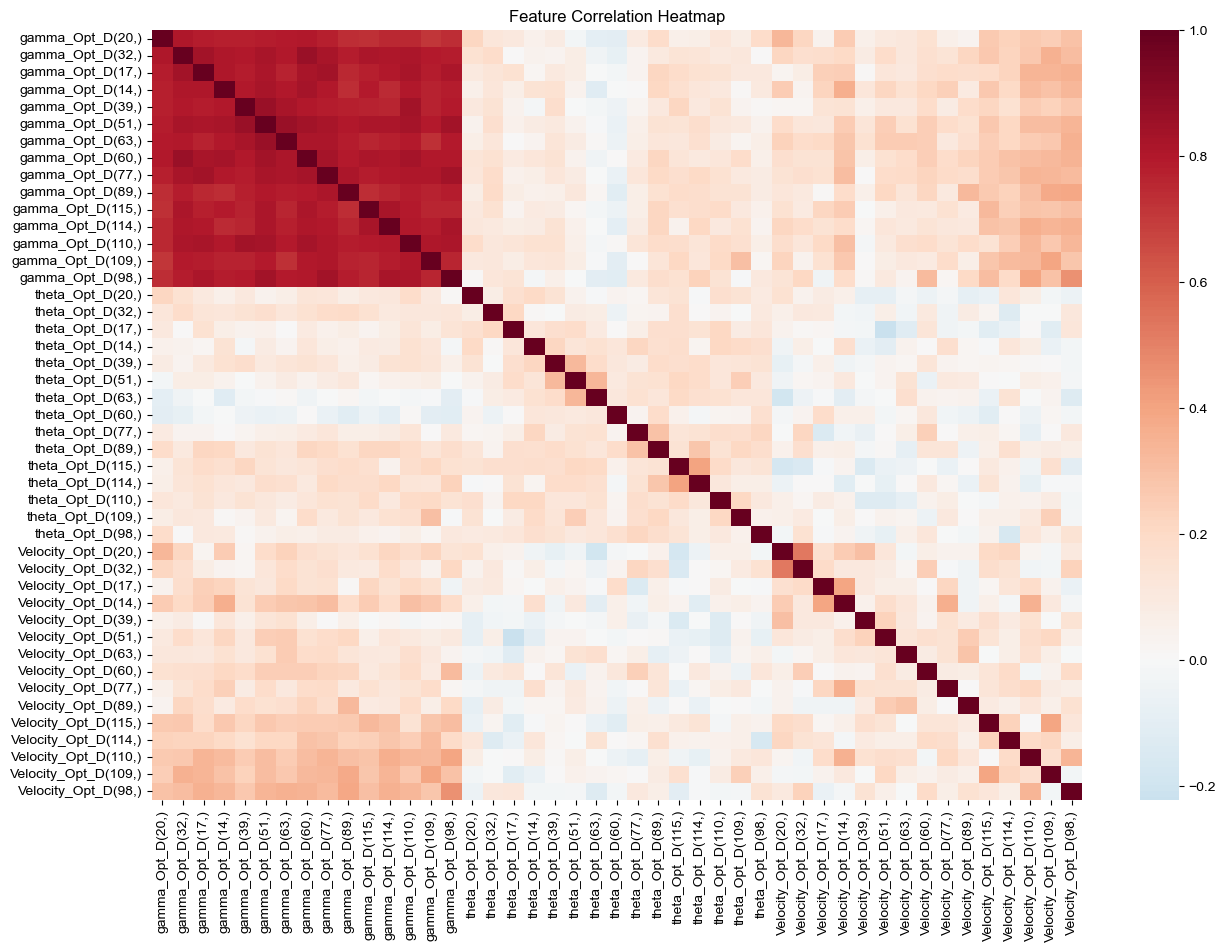

In [41]:
# Create the feature based correlation matrix 

plt.figure(figsize=(15, 10))
numeric_cols = [col for col in index_df.columns if col.startswith("gamma_Opt")]+[col for col in index_df.columns if col.startswith("theta_Opt")]+[col for col in index_df.columns if col.startswith("Velocity_Opt")]#+[col for col in index_df.columns if col.startswith("Prob")]

sns.heatmap(index_df.loc[index_df.Successful_bout=='Successful'][numeric_cols].corr(), annot=False, cmap='RdBu_r', fmt='.2f',center=0)
plt.title("Feature Correlation Heatmap")


# Boutwise Neural Dynamics

'Velocity' column already exists. Skipping velocity computation.


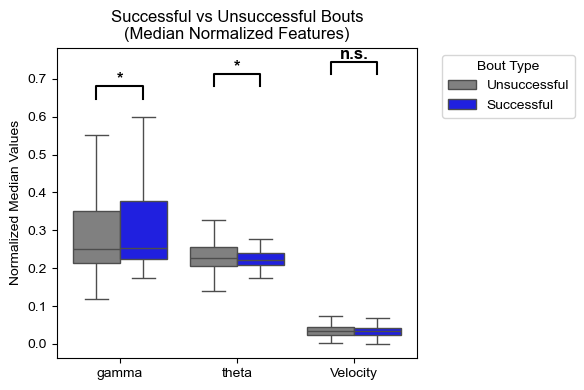

In [43]:
# ======================== USAGE EXAMPLE ======================== #
# This workflow compares normalized gamma/theta/velocity across bouts,
# grouped by whether they were Successful or Unsuccessful at reaching
# the Target Zone, within a specific Region (e.g., 'Reward Path').

# Example Workflow:
# -----------------

#--------------- SET THESE VALUES --------------#
features = ['gamma', 'theta', 'Velocity']

#________________________________________________________________

#CHECKS 
# Check for Bout_num column and if absent Assign Bout numbers to the dataframe
df_tot = assign_bout_numbers(df_tot, grid_anchor=47)
# Check if Velocity column exists and it creates it if absent
df_tot = ensure_velocity_column(df_tot, x_col='x', y_col='y', velocity_col='Velocity')


# Step 1: Normalize raw features across all data
df_norm = normalize_columns(df_tot, features)

# Step 2: Compute bout-wise median feature values and assign success/validity
index_df = compute_basic_bout_summary(
    df=df_norm,
    features=features,
    condition_col='Region',
    condition_filter='Reward Path',
    target_zone='Target Zone',
    valid_bout_threshold=0
)

# Step 3: Visualize feature differences across successful and unsuccessful bouts (Using Mixed LMM for stats)
plot_bout_metric_comparison(index_df, features)

# Gamma Trends at Decision Points across HHMM State transition points

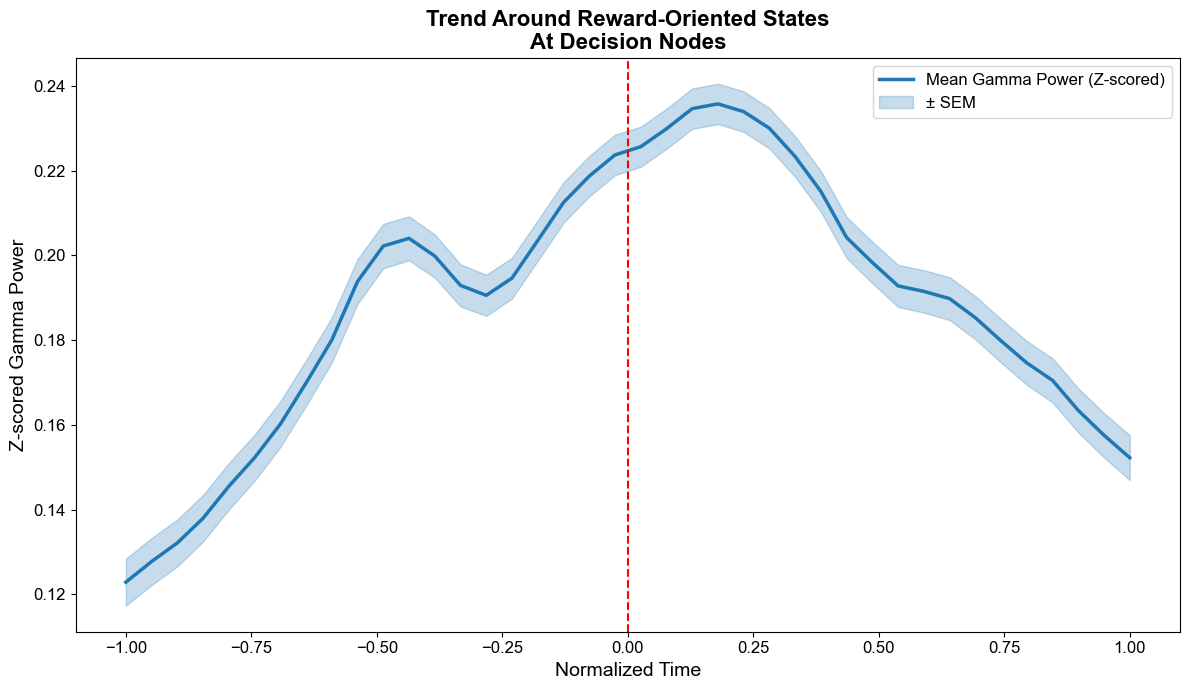

In [75]:
# ======================== USAGE EXAMPLE ======================== #
# This workflow extracts gamma power trends before and after specific HHMM states
# at decision nodes, normalizes them, and plots the mean ± SEM across time-aligned windows.

# Recommended Use:
# ----------------
# 1. Ensure your dataframe contains:
#    - 'Session', 'gamma', 'HHMM State', and 'Grid.Number' columns
# 2. Call `aggregate_metric_trend()` with the desired metric, e.g., 'gamma', 'theta', or 'Velocity'

# Example Workflow:
# -----------------

#--------------- SET THESE VALUES --------------#
# Set decision node list and metric
metric = 'gamma'
window_size = 20  # 4 seconds before and after at 5 Hz
target_states = ['Ambulatory, Reward-oriented', 'Active Surveillance, Reward-oriented']
decision_nodes = Decision_Reward 


#_________________________________________________________________________
# Run the analysis

aggregate_metric_trend(
    df=df_tot,
    metric=metric,
    window_size=window_size,
    states=target_states,
    node_filter=decision_nodes
)



# UMAPS

C:\Users\shreya.bangera\AppData\Local\Temp\ipykernel_45240\450751053.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature_col] = (df[feature_col] - df[feature_col].mean()) / df[feature_col].std()
C:\Users\shreya.bangera\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\shreya.bangera\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


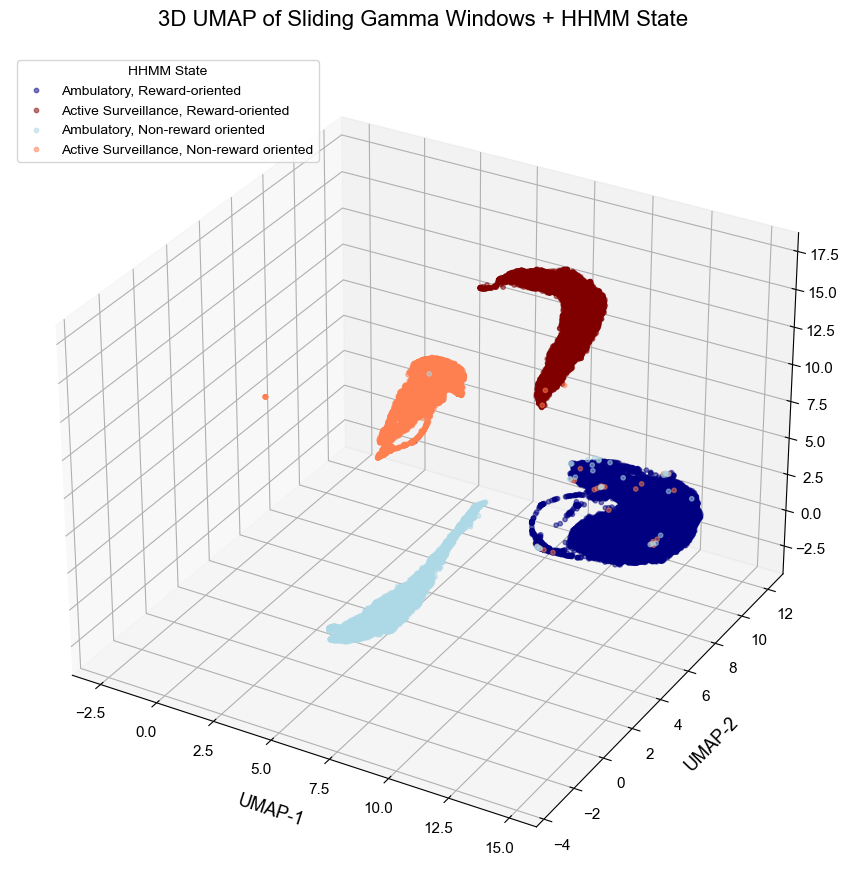

In [64]:
# ======================== UMAP USAGE EXAMPLE ======================== #
# This workflow applies UMAP on sliding window segments of a signal
# (e.g., gamma power) centered on decision node frames. The dimensionality
# reduction reveals structure in local temporal dynamics of the feature
# across HHMM States.

# Recommended Use:
# ----------------
# 1. Ensure your dataframe contains the following columns:
#    - 'gamma' or another continuous feature
#    - 'HHMM State': categorical behavioral state
#    - 'Grid.Number': identifies spatial node per frame
#    - 'Session': for optional filtering

# 2. Prepare your list of decision nodes (e.g., `Decision_Reward = [30, 47, ...]`)

# 3. Run `run_umap_embedding()` to compute UMAP embeddings.
# 4. Use `plot_umap_3d()` to visualize structure across states.

# Example Workflow:
# -----------------

# ---------- SET THESE VALUES ---------- #
window_size = 10
feature_col = 'gamma'
state_col = 'HHMM State'
grid_col = 'Grid.Number'
node_list = Decision_Reward  # Define this list before running
session_filter = None  # Or set to specific session number

# HHMM State → Color Map
state_color_map = {
    'Ambulatory, Reward-oriented': 'navy',
    'Active Surveillance, Reward-oriented': 'maroon',
    'Ambulatory, Non-reward oriented': 'lightblue',
    'Active Surveillance, Non-reward oriented': 'coral'
}

#__________________________________________________________

# ---------- Run UMAP ---------- #
embedding, labels = umap_embedding(
    df=df_tot.loc[~df_tot['Grid.Number'].isin([47])], # removing bout starting/ending nodes 47
    window_size=window_size,
    feature_col=feature_col,
    state_col=state_col,
    grid_col=grid_col,
    node_list=node_list,
    session_filter=session_filter
)

# ---------- Plot 3D Embedding ---------- #
plot_umap_3d(
    embedding,
    labels,
    state_color_map=state_color_map,
    title="3D UMAP of Sliding Gamma Windows + HHMM State"
)


# UMAP - Temporal Progression

C:\Users\shreya.bangera\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\shreya.bangera\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


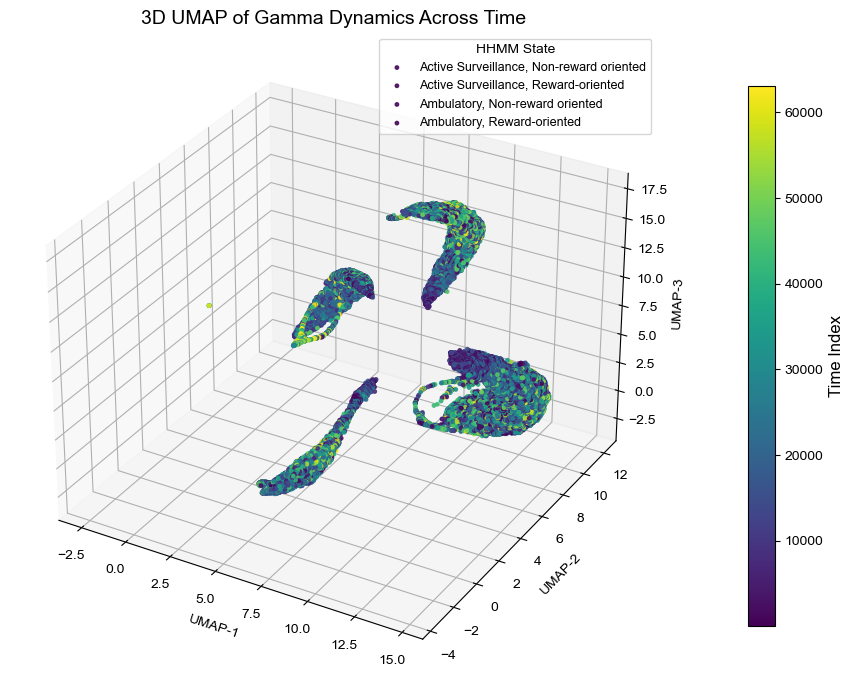

In [ ]:
# ======================== TEMPORAL UMAP USAGE EXAMPLE ======================== #
# This workflow applies UMAP on sliding window segments of a signal
# (e.g., gamma power) centered on decision node frames. By incorporating
# signal context and HHMM state information around each decision point,
# the dimensionality reduction reveals temporal structure in local bouts
# of behavior — capturing how neural dynamics evolve across time.

# Recommended Use:
# ----------------
# 1. Ensure your dataframe contains the following columns:
#    - 'gamma' or another continuous feature (e.g., theta, velocity)
#    - 'HHMM State': categorical labels representing latent behavioral states
#    - 'Grid.Number': spatial grid identifier per time point
#    - 'Session': optional, but required for computing within-session time index (T_Index)

# 2. Prepare a list of decision nodes (e.g., `Decision_Reward`)
#    These are grid locations where meaningful navigational choices occur.

# 3. Use `compute_umap_embedding_temporal()` to:
#    - Extract overlapping windows centered on decision frames
#    - Concatenate signal segment + one-hot HHMM state at middle frame
#    - Apply UMAP to reduce each temporal window into 3D coordinates

# 4. Visualize with `plot_umap_embedding_temporal_3d()` to:
#    - Color by in-session time index (T_Index)
#    - Reveal temporal evolution within and across HHMM states

# Example Workflow:
# -----------------


# --- Temporal UMAP ---
embedding_t, labels_t, t_idx = compute_umap_embedding_temporal(
    df=df_tot.loc[~df_tot['Grid.Number'].isin([47])],
    window_size=window_size,
    gamma_col=feature_col,
    state_col=state_col,
    grid_col=grid_col,
    decision_nodes=node_list,
    session_filter=session_filter
)

plot_umap_embedding_temporal_3d(
    embedding_t, labels_t, t_idx,
    title="3D UMAP of Gamma Dynamics Across Time"
)

# Classification Modeling

c:\Users\shreya.bangera\AppData\Local\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:10:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\shreya.bangera\AppData\Local\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:10:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\shreya.bangera\AppData\Local\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:10:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\shreya.bangera\AppData\Local\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:10:48] WARNING: C:\actions-runner\_work\xgboost\xgbo


Mean AUCs: AUC_XGB    0.773780
AUC_RF     0.765021
AUC_LR     0.784546
dtype: float64


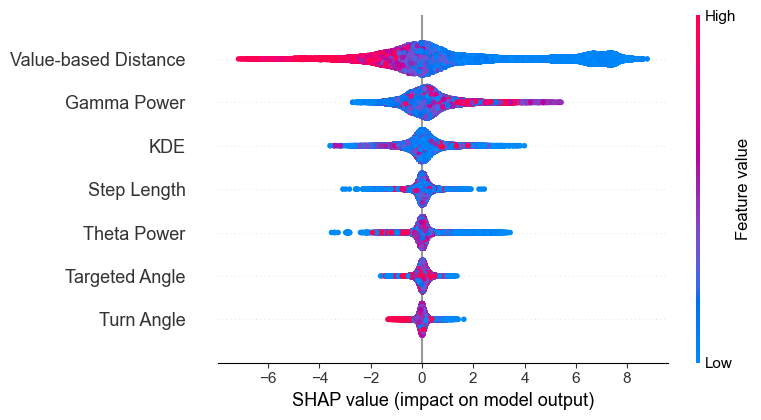

c:\Users\shreya.bangera\AppData\Local\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:14:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


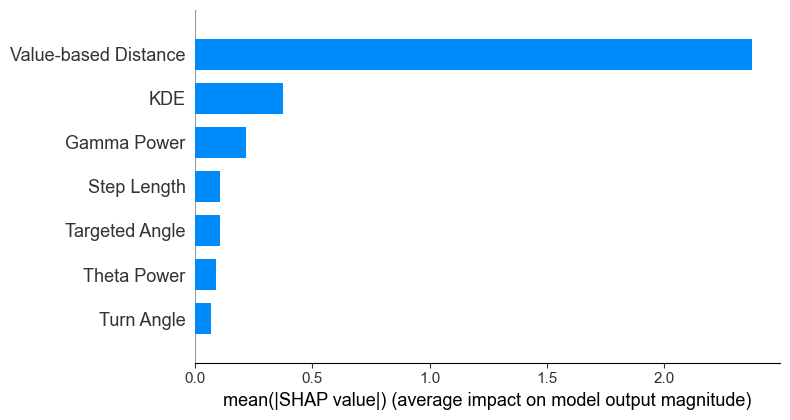

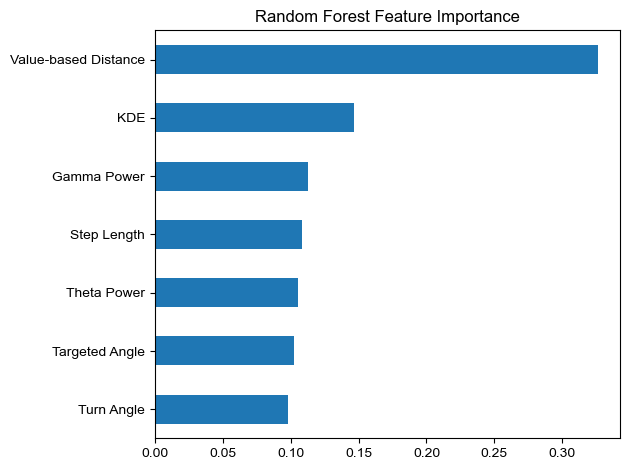

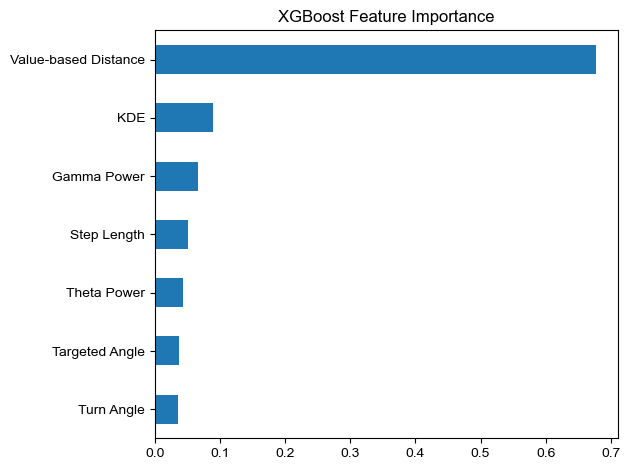

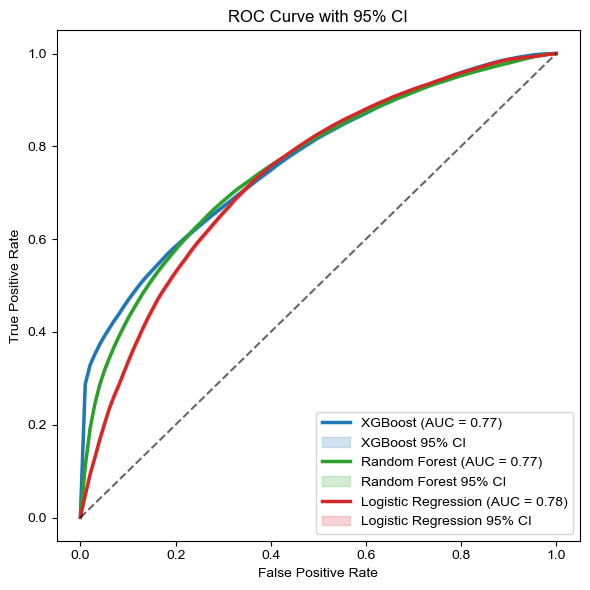

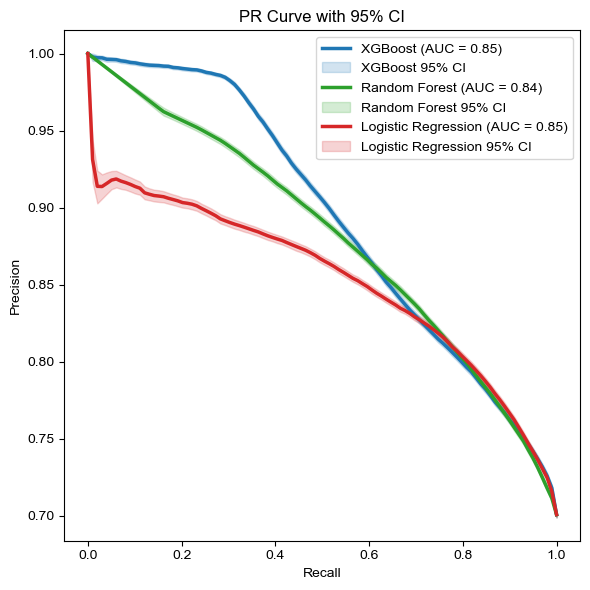

In [91]:
# ======================== CLASSIFICATION MODELLING EXAMPLE ======================== #
# This workflow evaluates how well behavioral and neural features predict bout success
# using session-wise cross-validation nested within time-based phase segments.
# It applies XGBoost, Random Forest, and Logistic Regression models to distinguish
# Successful vs Unsuccessful bouts, and summarizes results with confidence intervals.

# Recommended Use:
# ----------------
# 1. Ensure your dataframe (`df_tot`) contains:
#    - 'Successful_bout': categorical outcome with values 'Successful' / 'Unsuccessful'
#    - 'Session': session identifier per row
#    - 'Grid.Number': spatial grid index (used to select relevant decision zones)
#    - Optional columns: gamma, theta, KDE, etc. (used as predictors)

# 2. Define features of interest via `feature_name_map`
#    This maps raw column names to readable labels for plots.

# 3. Use `assign_phase_blocks(df)` to:
#    - Segment each session into fixed-length frame blocks (phases)
#    - Enables time-aware cross-validation by leaving out one session per phase

# 4. Run `run_phase_session_models()` to:
#    - Train models per Phase-Session split
#    - Collect predicted probabilities and SHAP values for each held-out session

# 5. Call `summarize_and_plot_all()` to:
#    - Print average AUCs
#    - Visualize SHAP summary plots (bar and dot)
#    - Plot ROC and PR curves with 95% confidence intervals
#    - Compare session-wise vs bootstrapped CI if needed

# Example Workflow:
# -----------------

#------------------------ SET THESE VALUES -----------------------#

# Define feature mappings for readability in plots
# This dictionary maps internal feature column names to more interpretable labels
feature_name_map = {
    'KDE': 'KDE',
    'step': 'Step Length',
    'angle': 'Turn Angle',
    'Targeted_Angle_smooth_abs': 'Targeted Angle',
    'gamma': 'Gamma Power',
    'theta': 'Theta Power',
    'VB_Distance': 'Value-based Distance',
}

# List of features to use in modeling
feature_cols = list(feature_name_map.keys())


#_________________________________________________________________________
# Step 1: Assign phase blocks within each session
# This segments each session into fixed-size frame chunks (e.g., 3000 frames per phase),
# allowing phase-wise and session-wise cross-validation later.
df_tot = assign_phase_blocks(df_tot,block_size=3000)

# Step 2: Prepare the modeling dataframe
# Copy the dataframe and encode the target variable: 1 for Successful, 0 for Unsuccessful bouts
df_model = df_tot.copy()
df_model['Successful_bout'] = df_model['Successful_bout'].map({'Successful': 1, 'Unsuccessful': 0})

# Step 3: Run phase-session cross-validation
# Trains XGBoost, Random Forest, and Logistic Regression models by leaving out one session per phase,
# collects performance metrics, SHAP values, and predictions for each fold
metrics, shap_vals, shap_feats, y_true_all, prob_xgb, prob_rf, prob_lr, X_all, y_all = run_phase_session_models(
    df_model, feature_cols, feature_name_map
)

# Step 4: Summarize and visualize results
# - Prints mean AUC scores
# - Shows SHAP value summary plots (bar + dot)
# - Plots feature importance from Random Forest and XGBoost
# - Plots ROC and PR curves with 95% CI (based on session-wise or bootstrap aggregation)
summarize_and_plot_all(
    metrics,
    shap_vals,
    shap_feats,
    X_all,
    y_all,
    feature_cols,
    feature_name_map,
    y_true_all,
    prob_xgb,
    prob_rf,
    prob_lr,
    use_bootstrap=True  # Set to False to use session-wise CI instead of bootstrap CI
)
